## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, GlobalAveragePooling2D, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('../data/new_data.npy', 'rb') as f:
    X_trains = np.load(f)
    X_letter = np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)
    TEST_letter = np.load(f)

In [5]:
print(X_trains.shape)
print(X_letter.shape)
print(y_trains.shape)
print(TEST.shape)
print(TEST_letter.shape)

(10240, 28, 28, 3)
(10240, 26)
(10240, 10)
(20480, 28, 28, 3)
(20480, 26)


In [6]:
X_trains = X_trains.astype('float32')
X_letter = X_letter.astype('float32')
TEST_letter = TEST_letter.astype('float32')
TEST = TEST.astype('float32')

In [7]:
X_trains = X_trains/255.
TEST = TEST/255.

### Your Model

주석 처리된 것처럼 함수형태로 만들어야 합니다.

### RexNet

In [8]:
reduction_ratio=16

def rexnet_model(shape):
    inputs = Input(shape=(28,28,3))
    letter = Input(shape=(26))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
    con = tf.keras.layers.concatenate([flatten1, letter],axis=1)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=[inputs,letter], outputs=outputs)

    return model

### DenseNet

In [9]:
layers_in_block = {'DenseNet-121':[6, 12, 24, 16],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

base_growth_rate = 32

def Conv_block(x, growth_rate, activation='relu'):
    x_l = BatchNormalization()(x)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate, (3,3), padding='same', kernel_initializer='he_normal')(x_l)
    
    x = concatenate([x, x_l])
    return x

def Dense_block(x, layers, growth_rate=32):
    for i in range(layers):
        x = Conv_block(x, growth_rate)
    return x

def Transition_layer(x, compression_factor=0.5, activation='relu'):
    reduced_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(reduced_filters, (1,1), padding='same', kernel_initializer='he_normal')(x)
    
    x = AveragePooling2D((2,2), padding='same', strides=2)(x)
    return x

#### DenseNet-121

In [10]:
def DenseNet_121(shape, densenet_type='DenseNet-121'):
    model_input = Input(shape=(28,28,3))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

#### DenseNet-169

In [11]:
def DenseNet_169(shape, densenet_type='DenseNet-169'):
    model_input = Input(shape=(28,28,3))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

#### DenseNet-201

In [12]:
def DenseNet_201(shape, densenet_type='DenseNet-201'):
    model_input = Input(shape=(28,28,3))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

#### DenseNet-265

In [13]:
def DenseNet_265(shape, densenet_type='DenseNet-265'):
    model_input = Input(shape=(28,28,3))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

In [14]:
def get_stacking(in_model, model_name, train, train_y, letter, n_fold = 4, SEED=2020, epochs = 500, batch_size = 32, lr_=0.001, es_p = 100, rlp_p = 30, rlp_f = 0.7):
    k_fold = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)
    
    history = []
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        t_letter, v_letter = letter[train_idx], letter[val_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=lr_, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=es_p, verbose=1,monitor = 'val_accuracy')
        mc = ModelCheckpoint(f'../model/{in_model}_{model_name}_best_{cnt+1}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=rlp_p, factor=rlp_f, min_lr=0.00001)
        
        history = model.fit([x_train, t_letter], y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=([x_val, v_letter], y_val),
                            verbose=1,
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            validation_steps=x_val.shape[0] // batch_size,
                            callbacks=[es, mc, rlp]
                            )
        
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        print("load model and predict")
        model.load_weights(f'../model/{in_model}_{model_name}_best_{cnt+1}.h5')
        print("valid acc")
        x_val_acc = model.evaluate([x_val, v_letter], y_val)
        print("\n\n\n")
        pred_train = model.predict([x_val, v_letter])
        pred_test = model.predict([TEST, TEST_letter])
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

### RexNet

In [15]:
epochs = 300
batch_size = 32
n_fold = 4
seed = 2020
model_name = "test0.1" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 70 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=30 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.7 # 감소시키는 비율 learing rate := learing rate * factor

*******************number_1_kfold_model*******************
Epoch 1/300
239/240 [============================>.] - ETA: 0s - loss: 2.9099 - accuracy: 0.2559
Epoch 00001: val_loss improved from inf to 4.60299, saving model to ../model/<function rexnet_model at 0x7f107c1f5dd0>_test0.1_best_1.h5
240/240 [==============================] - 11s 44ms/step - loss: 2.9061 - accuracy: 0.2570 - val_loss: 4.6030 - val_accuracy: 0.1977 - lr: 0.0010
Epoch 2/300
239/240 [============================>.] - ETA: 0s - loss: 1.7528 - accuracy: 0.4514
Epoch 00002: val_loss improved from 4.60299 to 2.33508, saving model to ../model/<function rexnet_model at 0x7f107c1f5dd0>_test0.1_best_1.h5
240/240 [==============================] - 10s 43ms/step - loss: 1.7542 - accuracy: 0.4508 - val_loss: 2.3351 - val_accuracy: 0.4184 - lr: 0.0010
Epoch 3/300
239/240 [============================>.] - ETA: 0s - loss: 1.4468 - accuracy: 0.5407
Epoch 00003: val_loss improved from 2.33508 to 1.63227, saving model to ../model

Epoch 27/300
239/240 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8981
Epoch 00027: val_loss did not improve from 0.68958
240/240 [==============================] - 10s 42ms/step - loss: 0.3825 - accuracy: 0.8984 - val_loss: 0.7652 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 28/300
239/240 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.9013
Epoch 00028: val_loss did not improve from 0.68958
240/240 [==============================] - 10s 42ms/step - loss: 0.3657 - accuracy: 0.9012 - val_loss: 0.9104 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 29/300
239/240 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.8992
Epoch 00029: val_loss improved from 0.68958 to 0.67975, saving model to ../model/<function rexnet_model at 0x7f107c1f5dd0>_test0.1_best_1.h5
240/240 [==============================] - 10s 43ms/step - loss: 0.3922 - accuracy: 0.8993 - val_loss: 0.6798 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 30/300
239/240 [===

239/240 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.9374
Epoch 00054: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.2790 - accuracy: 0.9374 - val_loss: 0.9081 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 55/300
239/240 [============================>.] - ETA: 0s - loss: 0.3202 - accuracy: 0.9334
Epoch 00055: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.3197 - accuracy: 0.9335 - val_loss: 1.0247 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 56/300
239/240 [============================>.] - ETA: 0s - loss: 0.3139 - accuracy: 0.9393
Epoch 00056: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.3136 - accuracy: 0.9395 - val_loss: 1.0507 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 57/300
239/240 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.9391
Epoch 00057: val_loss did not 

Epoch 82/300
239/240 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9672
Epoch 00082: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.1624 - accuracy: 0.9672 - val_loss: 0.8982 - val_accuracy: 0.8906 - lr: 7.0000e-04
Epoch 83/300
239/240 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9720
Epoch 00083: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.1591 - accuracy: 0.9721 - val_loss: 0.8342 - val_accuracy: 0.9066 - lr: 7.0000e-04
Epoch 84/300
239/240 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9689
Epoch 00084: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.1621 - accuracy: 0.9690 - val_loss: 1.8236 - val_accuracy: 0.8547 - lr: 7.0000e-04
Epoch 85/300
239/240 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9682
Epoch

Epoch 110/300
239/240 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9873
Epoch 00110: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0718 - accuracy: 0.9874 - val_loss: 1.1260 - val_accuracy: 0.9023 - lr: 4.9000e-04
Epoch 111/300
239/240 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9881
Epoch 00111: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0632 - accuracy: 0.9882 - val_loss: 1.1581 - val_accuracy: 0.8965 - lr: 4.9000e-04
Epoch 112/300
239/240 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9877
Epoch 00112: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0615 - accuracy: 0.9878 - val_loss: 0.9984 - val_accuracy: 0.8969 - lr: 4.9000e-04
Epoch 113/300
239/240 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9852
E

239/240 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9939
Epoch 00137: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0237 - accuracy: 0.9939 - val_loss: 1.1694 - val_accuracy: 0.9168 - lr: 3.4300e-04
Epoch 138/300
239/240 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9950
Epoch 00138: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0279 - accuracy: 0.9951 - val_loss: 1.1211 - val_accuracy: 0.9152 - lr: 3.4300e-04
Epoch 139/300
239/240 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9941
Epoch 00139: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 43ms/step - loss: 0.0310 - accuracy: 0.9941 - val_loss: 1.5285 - val_accuracy: 0.9074 - lr: 3.4300e-04
Epoch 140/300
239/240 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9908
Epoch 00140: va

Epoch 165/300
239/240 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9971
Epoch 00165: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0148 - accuracy: 0.9971 - val_loss: 0.9140 - val_accuracy: 0.9309 - lr: 2.4010e-04
Epoch 166/300
239/240 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9979
Epoch 00166: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.9491 - val_accuracy: 0.9215 - lr: 2.4010e-04
Epoch 167/300
239/240 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9973
Epoch 00167: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0147 - accuracy: 0.9971 - val_loss: 1.0128 - val_accuracy: 0.9215 - lr: 2.4010e-04
Epoch 168/300
239/240 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9953
E

239/240 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9986
Epoch 00192: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 43ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.8270 - val_accuracy: 0.9379 - lr: 1.6807e-04
Epoch 193/300
239/240 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9987
Epoch 00193: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.8250 - val_accuracy: 0.9395 - lr: 1.6807e-04
Epoch 194/300
239/240 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9974
Epoch 00194: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 43ms/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.9566 - val_accuracy: 0.9238 - lr: 1.6807e-04
Epoch 195/300
239/240 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9986
Epoch 00195: va

Epoch 220/300
239/240 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9991
Epoch 00220: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 1.0867 - val_accuracy: 0.9332 - lr: 1.1765e-04
Epoch 221/300
239/240 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9992
Epoch 00221: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.9527 - val_accuracy: 0.9371 - lr: 1.1765e-04
Epoch 222/300
239/240 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9987
Epoch 00222: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.9309 - val_accuracy: 0.9367 - lr: 1.1765e-04
Epoch 223/300
239/240 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9990
E

239/240 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9987
Epoch 00247: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 43ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 1.0804 - val_accuracy: 0.9301 - lr: 1.1765e-04
Epoch 248/300
239/240 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9983
Epoch 00248: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 42ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 1.0623 - val_accuracy: 0.9320 - lr: 8.2354e-05
Epoch 249/300
239/240 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9988
Epoch 00249: val_loss did not improve from 0.63871
240/240 [==============================] - 10s 43ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 1.0104 - val_accuracy: 0.9344 - lr: 8.2354e-05
Epoch 250/300
239/240 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997
Epoch 00250: va

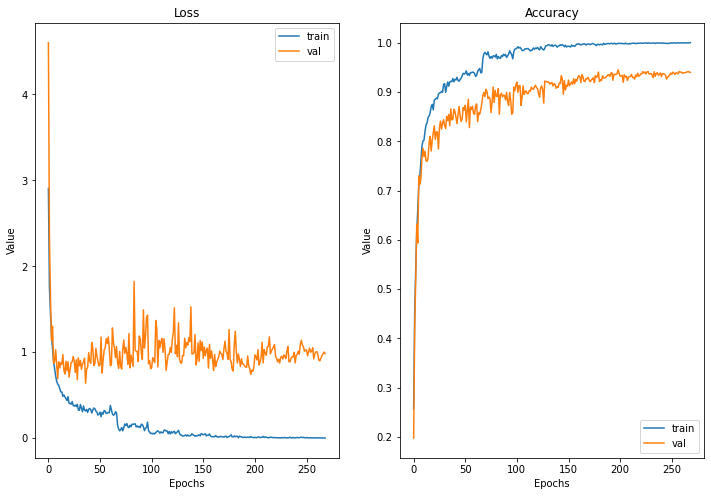

load model and predict
valid acc
80/80 [==============================] - 1s 11ms/step - loss: 0.6387 - accuracy: 0.8656




*******************number_2_kfold_model*******************
Epoch 1/300
240/240 [==============================] - ETA: 0s - loss: 2.8359 - accuracy: 0.2738
Epoch 00001: val_loss improved from inf to 4.49593, saving model to ../model/<function rexnet_model at 0x7f107c1f5dd0>_test0.1_best_2.h5
240/240 [==============================] - 11s 45ms/step - loss: 2.8359 - accuracy: 0.2738 - val_loss: 4.4959 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 2/300
239/240 [============================>.] - ETA: 0s - loss: 1.7749 - accuracy: 0.4387
Epoch 00002: val_loss improved from 4.49593 to 1.76471, saving model to ../model/<function rexnet_model at 0x7f107c1f5dd0>_test0.1_best_2.h5
240/240 [==============================] - 11s 44ms/step - loss: 1.7730 - accuracy: 0.4392 - val_loss: 1.7647 - val_accuracy: 0.4727 - lr: 0.0010
Epoch 3/300
239/240 [============================>.]

Epoch 26/300
240/240 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8987
Epoch 00026: val_loss did not improve from 0.57207
240/240 [==============================] - 10s 43ms/step - loss: 0.3718 - accuracy: 0.8987 - val_loss: 0.7496 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 27/300
239/240 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8887
Epoch 00027: val_loss did not improve from 0.57207
240/240 [==============================] - 10s 43ms/step - loss: 0.4076 - accuracy: 0.8887 - val_loss: 0.6388 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 28/300
239/240 [============================>.] - ETA: 0s - loss: 0.3847 - accuracy: 0.8945
Epoch 00028: val_loss did not improve from 0.57207
240/240 [==============================] - 10s 43ms/step - loss: 0.3840 - accuracy: 0.8945 - val_loss: 0.6290 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 29/300
239/240 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8991
Epoch 00029: val_

Epoch 54/300
239/240 [============================>.] - ETA: 0s - loss: 0.2919 - accuracy: 0.9336
Epoch 00054: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 43ms/step - loss: 0.2948 - accuracy: 0.9331 - val_loss: 0.8801 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 55/300
239/240 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.9297
Epoch 00055: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 43ms/step - loss: 0.3391 - accuracy: 0.9298 - val_loss: 0.9634 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 56/300
239/240 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.9328
Epoch 00056: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 42ms/step - loss: 0.3242 - accuracy: 0.9328 - val_loss: 0.7620 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 57/300
239/240 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.9450
Epoch 00057: val_

Epoch 82/300
239/240 [============================>.] - ETA: 0s - loss: 0.1340 - accuracy: 0.9732
Epoch 00082: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 42ms/step - loss: 0.1335 - accuracy: 0.9733 - val_loss: 0.9886 - val_accuracy: 0.8910 - lr: 7.0000e-04
Epoch 83/300
239/240 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9740
Epoch 00083: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 42ms/step - loss: 0.1381 - accuracy: 0.9738 - val_loss: 1.1722 - val_accuracy: 0.9027 - lr: 7.0000e-04
Epoch 84/300
240/240 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9730
Epoch 00084: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 44ms/step - loss: 0.1500 - accuracy: 0.9730 - val_loss: 1.2259 - val_accuracy: 0.8590 - lr: 7.0000e-04
Epoch 85/300
239/240 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9745
Epoch

Epoch 110/300
239/240 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9880
Epoch 00110: val_loss did not improve from 0.55700
240/240 [==============================] - 10s 41ms/step - loss: 0.0611 - accuracy: 0.9880 - val_loss: 0.9006 - val_accuracy: 0.9223 - lr: 4.9000e-04
Epoch 111/300
239/240 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9902
Epoch 00111: val_loss did not improve from 0.55700
240/240 [==============================] - 9s 38ms/step - loss: 0.0430 - accuracy: 0.9902 - val_loss: 1.6762 - val_accuracy: 0.8793 - lr: 4.9000e-04
Epoch 112/300
239/240 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9833
Epoch 00112: val_loss did not improve from 0.55700
240/240 [==============================] - 8s 35ms/step - loss: 0.0953 - accuracy: 0.9832 - val_loss: 0.8291 - val_accuracy: 0.9211 - lr: 4.9000e-04
Epoch 113/300
239/240 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9837
Epo

In [ ]:
model_train, model_test = get_stacking(rexnet_model, model_name, X_trains, y_trains, X_letter, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

In [ ]:
pickle.dump(model_train, open("../new_data/{}.pkl".format("test_train"), "wb"))
pickle.dump(model_test, open("../new_data/{}.pkl".format("test_test"), "wb"))

### DenseNet-121

In [35]:
epochs = 200
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet121" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 50 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

*******************number_1_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 2.9371 - accuracy: 0.1496
Epoch 00001: val_loss improved from inf to 3.21497, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_1.h5
56/56 [==============================] - 6s 116ms/step - loss: 2.9371 - accuracy: 0.1496 - val_loss: 3.2150 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.3180 - accuracy: 0.1981
Epoch 00002: val_loss improved from 3.21497 to 2.58043, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_1.h5
56/56 [==============================] - 6s 100ms/step - loss: 2.3180 - accuracy: 0.1981 - val_loss: 2.5804 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.1074 - accuracy: 0.2394
Epoch 00003: val_loss did not improve from 2.58043
56/56 [============================

Epoch 54/200
56/56 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8594
Epoch 00054: val_loss did not improve from 0.98161
56/56 [==============================] - 5s 85ms/step - loss: 0.4158 - accuracy: 0.8594 - val_loss: 1.0799 - val_accuracy: 0.7070 - lr: 1.5625e-05
Epoch 55/200
56/56 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8677
Epoch 00055: val_loss did not improve from 0.98161
56/56 [==============================] - 5s 87ms/step - loss: 0.3922 - accuracy: 0.8677 - val_loss: 1.1295 - val_accuracy: 0.7188 - lr: 1.5625e-05
Epoch 56/200
56/56 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8744
Epoch 00056: val_loss did not improve from 0.98161
56/56 [==============================] - 5s 85ms/step - loss: 0.3792 - accuracy: 0.8744 - val_loss: 1.2028 - val_accuracy: 0.7070 - lr: 1.0000e-05
Epoch 57/200
56/56 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8677
Epoch 00057: val_loss 

Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8878
Epoch 00082: val_loss did not improve from 0.95577
56/56 [==============================] - 5s 86ms/step - loss: 0.3319 - accuracy: 0.8878 - val_loss: 1.1731 - val_accuracy: 0.7148 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8834
Epoch 00083: val_loss did not improve from 0.95577
56/56 [==============================] - 5s 86ms/step - loss: 0.3513 - accuracy: 0.8834 - val_loss: 1.1303 - val_accuracy: 0.7461 - lr: 1.0000e-05
Epoch 84/200
56/56 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8705
Epoch 00084: val_loss did not improve from 0.95577
56/56 [==============================] - 5s 87ms/step - loss: 0.3593 - accuracy: 0.8705 - val_loss: 1.2381 - val_accuracy: 0.7188 - lr: 1.0000e-05
Epoch 85/200
56/56 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8728
Epoch 00085: val_loss 

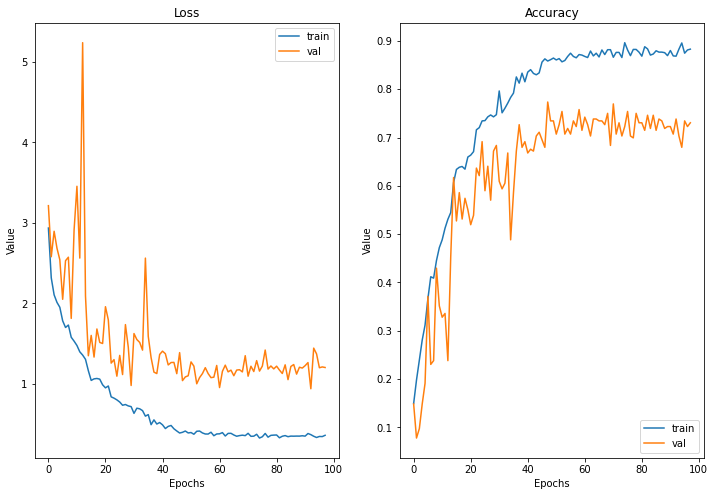

load model and predict
valid acc
8/8 [==============================] - 0s 20ms/step - loss: 1.2726 - accuracy: 0.7148




*******************number_2_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 3.0589 - accuracy: 0.1512
Epoch 00001: val_loss improved from inf to 2.35544, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_2.h5
56/56 [==============================] - 6s 114ms/step - loss: 3.0589 - accuracy: 0.1512 - val_loss: 2.3554 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.2718 - accuracy: 0.2199
Epoch 00002: val_loss did not improve from 2.35544
56/56 [==============================] - 5s 85ms/step - loss: 2.2718 - accuracy: 0.2199 - val_loss: 2.7324 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.1157 - accuracy: 0.2422
Epoch 00003: val_loss improved from 2.35544 to 2.34208, 

Epoch 52/200
56/56 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8778
Epoch 00052: val_loss did not improve from 0.45962
56/56 [==============================] - 5s 87ms/step - loss: 0.3480 - accuracy: 0.8778 - val_loss: 0.5617 - val_accuracy: 0.8242 - lr: 6.2500e-05
Epoch 53/200
56/56 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8839
Epoch 00053: val_loss did not improve from 0.45962
56/56 [==============================] - 5s 85ms/step - loss: 0.3694 - accuracy: 0.8839 - val_loss: 0.5403 - val_accuracy: 0.8477 - lr: 6.2500e-05
Epoch 54/200
56/56 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8828
Epoch 00054: val_loss did not improve from 0.45962
56/56 [==============================] - 5s 86ms/step - loss: 0.3443 - accuracy: 0.8828 - val_loss: 0.5561 - val_accuracy: 0.8398 - lr: 3.1250e-05
Epoch 55/200
56/56 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.8901
Epoch 00055: val_loss 

Epoch 80/200
56/56 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8956
Epoch 00080: val_loss did not improve from 0.44109
56/56 [==============================] - 5s 87ms/step - loss: 0.3138 - accuracy: 0.8956 - val_loss: 0.5953 - val_accuracy: 0.8477 - lr: 1.0000e-05
Epoch 81/200
56/56 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8929
Epoch 00081: val_loss did not improve from 0.44109
56/56 [==============================] - 5s 86ms/step - loss: 0.3187 - accuracy: 0.8929 - val_loss: 0.6215 - val_accuracy: 0.8398 - lr: 1.0000e-05
Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9085
Epoch 00082: val_loss did not improve from 0.44109
56/56 [==============================] - 5s 86ms/step - loss: 0.2737 - accuracy: 0.9085 - val_loss: 0.5175 - val_accuracy: 0.8594 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8973
Epoch 00083: val_loss 

Epoch 108/200
56/56 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.9001
Epoch 00108: val_loss did not improve from 0.44109
56/56 [==============================] - 5s 86ms/step - loss: 0.3130 - accuracy: 0.9001 - val_loss: 0.7489 - val_accuracy: 0.8047 - lr: 1.0000e-05
Epoch 109/200
56/56 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9046
Epoch 00109: val_loss did not improve from 0.44109
56/56 [==============================] - 5s 85ms/step - loss: 0.2765 - accuracy: 0.9046 - val_loss: 0.7370 - val_accuracy: 0.8203 - lr: 1.0000e-05
Epoch 110/200
56/56 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9062
Epoch 00110: val_loss did not improve from 0.44109
56/56 [==============================] - 5s 87ms/step - loss: 0.2623 - accuracy: 0.9062 - val_loss: 0.6328 - val_accuracy: 0.8398 - lr: 1.0000e-05
Epoch 111/200
56/56 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9046
Epoch 00111: val_l

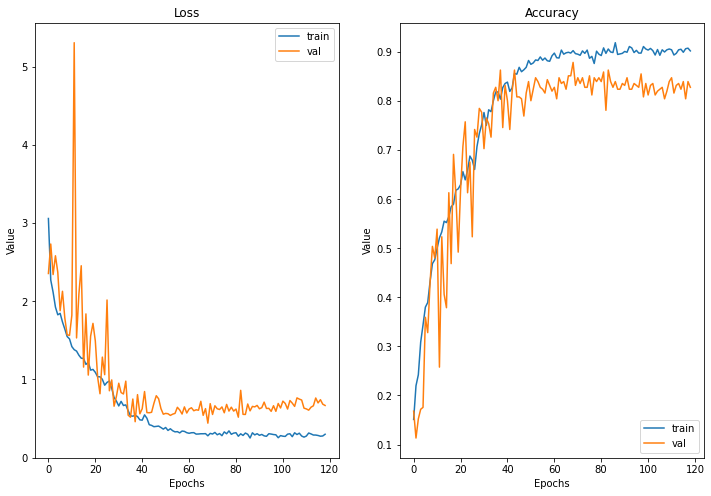

load model and predict
valid acc
8/8 [==============================] - 0s 21ms/step - loss: 0.5991 - accuracy: 0.8477




*******************number_3_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 2.9726 - accuracy: 0.1518
Epoch 00001: val_loss improved from inf to 3.96393, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_3.h5
56/56 [==============================] - 6s 112ms/step - loss: 2.9726 - accuracy: 0.1518 - val_loss: 3.9639 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.2501 - accuracy: 0.1998
Epoch 00002: val_loss improved from 3.96393 to 2.78358, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_3.h5
56/56 [==============================] - 6s 99ms/step - loss: 2.2501 - accuracy: 0.1998 - val_loss: 2.7836 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0

Epoch 26/200
56/56 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7383
Epoch 00026: val_loss improved from 0.78226 to 0.73923, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_3.h5
56/56 [==============================] - 5s 97ms/step - loss: 0.7587 - accuracy: 0.7383 - val_loss: 0.7392 - val_accuracy: 0.7422 - lr: 2.5000e-04
Epoch 27/200
56/56 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.7550
Epoch 00027: val_loss did not improve from 0.73923
56/56 [==============================] - 5s 85ms/step - loss: 0.7454 - accuracy: 0.7550 - val_loss: 0.9443 - val_accuracy: 0.7227 - lr: 2.5000e-04
Epoch 28/200
56/56 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7366
Epoch 00028: val_loss did not improve from 0.73923
56/56 [==============================] - 5s 91ms/step - loss: 0.7349 - accuracy: 0.7366 - val_loss: 0.7898 - val_accuracy: 0.7500 - lr: 2.5000e-04
Epoch 29/200
56/56 [======

Epoch 53/200
56/56 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.8616
Epoch 00053: val_loss did not improve from 0.68945
56/56 [==============================] - 5s 85ms/step - loss: 0.4163 - accuracy: 0.8616 - val_loss: 0.8784 - val_accuracy: 0.7695 - lr: 1.5625e-05
Epoch 54/200
56/56 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8700
Epoch 00054: val_loss did not improve from 0.68945
56/56 [==============================] - 5s 88ms/step - loss: 0.3787 - accuracy: 0.8700 - val_loss: 0.9117 - val_accuracy: 0.7422 - lr: 1.5625e-05
Epoch 55/200
56/56 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8633
Epoch 00055: val_loss did not improve from 0.68945
56/56 [==============================] - 5s 88ms/step - loss: 0.3965 - accuracy: 0.8633 - val_loss: 0.7724 - val_accuracy: 0.7891 - lr: 1.5625e-05
Epoch 56/200
56/56 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8722
Epoch 00056: val_loss 

Epoch 81/200
56/56 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8728
Epoch 00081: val_loss did not improve from 0.67414
56/56 [==============================] - 5s 87ms/step - loss: 0.3900 - accuracy: 0.8728 - val_loss: 0.8817 - val_accuracy: 0.7734 - lr: 1.0000e-05
Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8571
Epoch 00082: val_loss did not improve from 0.67414
56/56 [==============================] - 5s 85ms/step - loss: 0.4033 - accuracy: 0.8571 - val_loss: 0.9050 - val_accuracy: 0.7695 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8711
Epoch 00083: val_loss did not improve from 0.67414
56/56 [==============================] - 5s 87ms/step - loss: 0.3651 - accuracy: 0.8711 - val_loss: 0.7865 - val_accuracy: 0.7930 - lr: 1.0000e-05
Epoch 84/200
56/56 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8767
Epoch 00084: val_loss 

Epoch 109/200
56/56 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8767
Epoch 00109: val_loss did not improve from 0.67414
56/56 [==============================] - 5s 85ms/step - loss: 0.3617 - accuracy: 0.8767 - val_loss: 0.7060 - val_accuracy: 0.8047 - lr: 1.0000e-05
Epoch 110/200
56/56 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8750
Epoch 00110: val_loss did not improve from 0.67414
56/56 [==============================] - 5s 87ms/step - loss: 0.3573 - accuracy: 0.8750 - val_loss: 1.0949 - val_accuracy: 0.7617 - lr: 1.0000e-05
Epoch 111/200
56/56 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8895
Epoch 00111: val_loss did not improve from 0.67414
56/56 [==============================] - 5s 86ms/step - loss: 0.3360 - accuracy: 0.8895 - val_loss: 0.8169 - val_accuracy: 0.7773 - lr: 1.0000e-05
Epoch 112/200
56/56 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8789
Epoch 00112: val_l

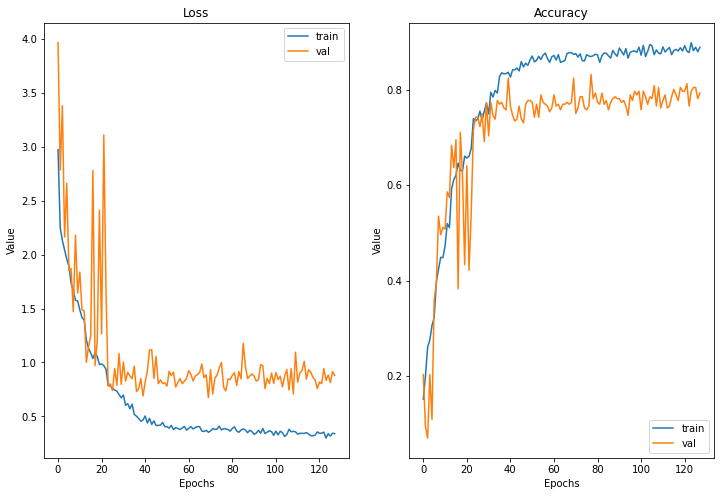

load model and predict
valid acc
8/8 [==============================] - 0s 21ms/step - loss: 0.8196 - accuracy: 0.7812




*******************number_4_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 2.8370 - accuracy: 0.1551
Epoch 00001: val_loss improved from inf to 2.33463, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_4.h5
56/56 [==============================] - 6s 112ms/step - loss: 2.8370 - accuracy: 0.1551 - val_loss: 2.3346 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.1884 - accuracy: 0.2294
Epoch 00002: val_loss did not improve from 2.33463
56/56 [==============================] - 5s 86ms/step - loss: 2.1884 - accuracy: 0.2294 - val_loss: 2.5265 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.0576 - accuracy: 0.2885
Epoch 00003: val_loss did not improve from 2.33463
56/56

Epoch 26/200
56/56 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.7779
Epoch 00026: val_loss did not improve from 0.75091
56/56 [==============================] - 5s 85ms/step - loss: 0.6417 - accuracy: 0.7779 - val_loss: 0.9307 - val_accuracy: 0.7227 - lr: 2.5000e-04
Epoch 27/200
56/56 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7985
Epoch 00027: val_loss did not improve from 0.75091
56/56 [==============================] - 5s 87ms/step - loss: 0.6015 - accuracy: 0.7985 - val_loss: 0.8743 - val_accuracy: 0.7695 - lr: 2.5000e-04
Epoch 28/200
56/56 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.7801
Epoch 00028: val_loss did not improve from 0.75091
56/56 [==============================] - 5s 85ms/step - loss: 0.6127 - accuracy: 0.7801 - val_loss: 1.0612 - val_accuracy: 0.7148 - lr: 2.5000e-04
Epoch 29/200
56/56 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.8008
Epoch 00029: val_loss 

Epoch 80/200
56/56 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9252
Epoch 00080: val_loss did not improve from 0.49944
56/56 [==============================] - 5s 85ms/step - loss: 0.2402 - accuracy: 0.9252 - val_loss: 0.6781 - val_accuracy: 0.8438 - lr: 1.0000e-05
Epoch 81/200
56/56 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9308
Epoch 00081: val_loss did not improve from 0.49944
56/56 [==============================] - 5s 86ms/step - loss: 0.2274 - accuracy: 0.9308 - val_loss: 0.7366 - val_accuracy: 0.8320 - lr: 1.0000e-05
Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9263
Epoch 00082: val_loss did not improve from 0.49944
56/56 [==============================] - 5s 86ms/step - loss: 0.2226 - accuracy: 0.9263 - val_loss: 0.7580 - val_accuracy: 0.8203 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9152
Epoch 00083: val_loss 

Epoch 108/200
56/56 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9219
Epoch 00108: val_loss did not improve from 0.49944
56/56 [==============================] - 5s 87ms/step - loss: 0.2267 - accuracy: 0.9219 - val_loss: 0.6296 - val_accuracy: 0.8281 - lr: 1.0000e-05
Epoch 109/200
56/56 [==============================] - ETA: 0s - loss: 0.2477 - accuracy: 0.9241
Epoch 00109: val_loss did not improve from 0.49944
56/56 [==============================] - 5s 86ms/step - loss: 0.2477 - accuracy: 0.9241 - val_loss: 0.8322 - val_accuracy: 0.7852 - lr: 1.0000e-05
Epoch 110/200
56/56 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9202
Epoch 00110: val_loss did not improve from 0.49944
56/56 [==============================] - 5s 86ms/step - loss: 0.2357 - accuracy: 0.9202 - val_loss: 0.7854 - val_accuracy: 0.8008 - lr: 1.0000e-05
Epoch 111/200
56/56 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9230
Epoch 00111: val_l

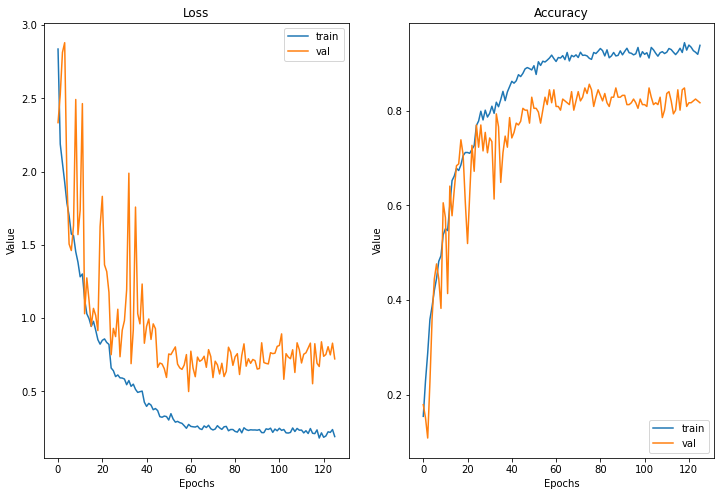

load model and predict
valid acc
8/8 [==============================] - 0s 20ms/step - loss: 0.6635 - accuracy: 0.8242




*******************number_5_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 2.8664 - accuracy: 0.1685
Epoch 00001: val_loss improved from inf to 2.78380, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_5.h5
56/56 [==============================] - 7s 120ms/step - loss: 2.8664 - accuracy: 0.1685 - val_loss: 2.7838 - val_accuracy: 0.1289 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.2767 - accuracy: 0.2048
Epoch 00002: val_loss did not improve from 2.78380
56/56 [==============================] - 5s 89ms/step - loss: 2.2767 - accuracy: 0.2048 - val_loss: 3.0754 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.1279 - accuracy: 0.2640
Epoch 00003: val_loss did not improve from 2.78380
56/56

Epoch 26/200
56/56 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.7360
Epoch 00026: val_loss did not improve from 0.83068
56/56 [==============================] - 4s 67ms/step - loss: 0.7712 - accuracy: 0.7360 - val_loss: 1.5054 - val_accuracy: 0.6367 - lr: 5.0000e-04
Epoch 27/200
56/56 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.7232
Epoch 00027: val_loss did not improve from 0.83068
56/56 [==============================] - 4s 67ms/step - loss: 0.8053 - accuracy: 0.7232 - val_loss: 2.9678 - val_accuracy: 0.4180 - lr: 5.0000e-04
Epoch 28/200
56/56 [==============================] - ETA: 0s - loss: 0.7776 - accuracy: 0.7238
Epoch 00028: val_loss did not improve from 0.83068
56/56 [==============================] - 4s 67ms/step - loss: 0.7776 - accuracy: 0.7238 - val_loss: 1.0974 - val_accuracy: 0.7031 - lr: 5.0000e-04
Epoch 29/200
56/56 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.7578
Epoch 00029: val_loss 

Epoch 53/200
56/56 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8683
Epoch 00053: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 67ms/step - loss: 0.3818 - accuracy: 0.8683 - val_loss: 0.9647 - val_accuracy: 0.8086 - lr: 3.1250e-05
Epoch 54/200
56/56 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8761
Epoch 00054: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 67ms/step - loss: 0.3455 - accuracy: 0.8761 - val_loss: 0.9344 - val_accuracy: 0.7930 - lr: 1.5625e-05
Epoch 55/200
56/56 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8839
Epoch 00055: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 67ms/step - loss: 0.3387 - accuracy: 0.8839 - val_loss: 0.8700 - val_accuracy: 0.8125 - lr: 1.5625e-05
Epoch 56/200
56/56 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8951
Epoch 00056: val_loss 

Epoch 81/200
56/56 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8912
Epoch 00081: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 67ms/step - loss: 0.3018 - accuracy: 0.8912 - val_loss: 1.0013 - val_accuracy: 0.7773 - lr: 1.0000e-05
Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8873
Epoch 00082: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 67ms/step - loss: 0.3249 - accuracy: 0.8873 - val_loss: 1.0215 - val_accuracy: 0.7969 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8850
Epoch 00083: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 67ms/step - loss: 0.3248 - accuracy: 0.8850 - val_loss: 1.0044 - val_accuracy: 0.7695 - lr: 1.0000e-05
Epoch 84/200
56/56 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8956
Epoch 00084: val_loss 

Epoch 109/200
56/56 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.9035
Epoch 00109: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 70ms/step - loss: 0.2899 - accuracy: 0.9035 - val_loss: 0.8629 - val_accuracy: 0.7852 - lr: 1.0000e-05
Epoch 110/200
56/56 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9135
Epoch 00110: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 70ms/step - loss: 0.2560 - accuracy: 0.9135 - val_loss: 0.9941 - val_accuracy: 0.7852 - lr: 1.0000e-05
Epoch 111/200
56/56 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8934
Epoch 00111: val_loss did not improve from 0.69837
56/56 [==============================] - 4s 68ms/step - loss: 0.3161 - accuracy: 0.8934 - val_loss: 1.0310 - val_accuracy: 0.7852 - lr: 1.0000e-05
Epoch 112/200
56/56 [==============================] - ETA: 0s - loss: 0.3093 - accuracy: 0.8940
Epoch 00112: val_l

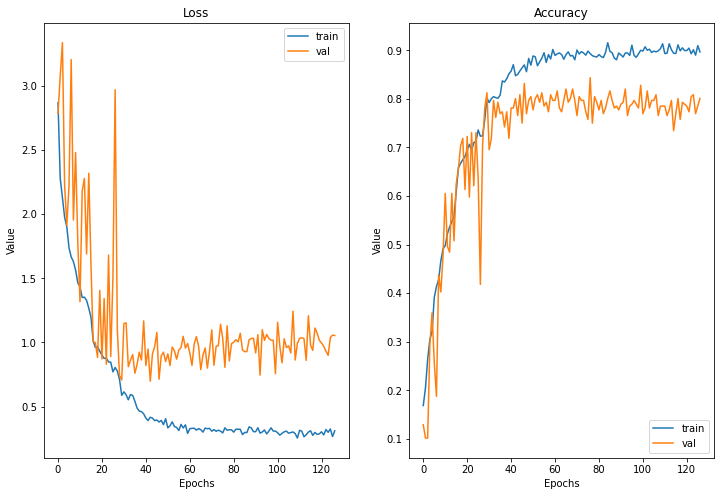

load model and predict
valid acc
8/8 [==============================] - 0s 15ms/step - loss: 0.7873 - accuracy: 0.7969




*******************number_6_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 3.0375 - accuracy: 0.1501
Epoch 00001: val_loss improved from inf to 2.26537, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_6.h5
56/56 [==============================] - 5s 92ms/step - loss: 3.0375 - accuracy: 0.1501 - val_loss: 2.2654 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.2266 - accuracy: 0.2115
Epoch 00002: val_loss did not improve from 2.26537
56/56 [==============================] - 4s 66ms/step - loss: 2.2266 - accuracy: 0.2115 - val_loss: 2.7292 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.1331 - accuracy: 0.2640
Epoch 00003: val_loss did not improve from 2.26537
56/56 

Epoch 54/200
56/56 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8504
Epoch 00054: val_loss did not improve from 0.79676
56/56 [==============================] - 4s 67ms/step - loss: 0.4215 - accuracy: 0.8504 - val_loss: 1.0194 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 55/200
56/56 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.8661
Epoch 00055: val_loss did not improve from 0.79676
56/56 [==============================] - 4s 67ms/step - loss: 0.3988 - accuracy: 0.8661 - val_loss: 1.0326 - val_accuracy: 0.7266 - lr: 1.0000e-05
Epoch 56/200
56/56 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8655
Epoch 00056: val_loss did not improve from 0.79676
56/56 [==============================] - 4s 71ms/step - loss: 0.3860 - accuracy: 0.8655 - val_loss: 1.0541 - val_accuracy: 0.7188 - lr: 1.0000e-05
Epoch 57/200
56/56 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8650
Epoch 00057: val_loss 

Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8638
Epoch 00082: val_loss did not improve from 0.79676
56/56 [==============================] - 4s 71ms/step - loss: 0.3774 - accuracy: 0.8638 - val_loss: 1.0911 - val_accuracy: 0.7578 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8739
Epoch 00083: val_loss did not improve from 0.79676
56/56 [==============================] - 4s 67ms/step - loss: 0.3869 - accuracy: 0.8739 - val_loss: 1.1490 - val_accuracy: 0.7109 - lr: 1.0000e-05
Epoch 84/200
56/56 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 0.8694
Epoch 00084: val_loss did not improve from 0.79676
56/56 [==============================] - 4s 67ms/step - loss: 0.3767 - accuracy: 0.8694 - val_loss: 1.1513 - val_accuracy: 0.7344 - lr: 1.0000e-05
Epoch 85/200
56/56 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8761
Epoch 00085: val_loss 

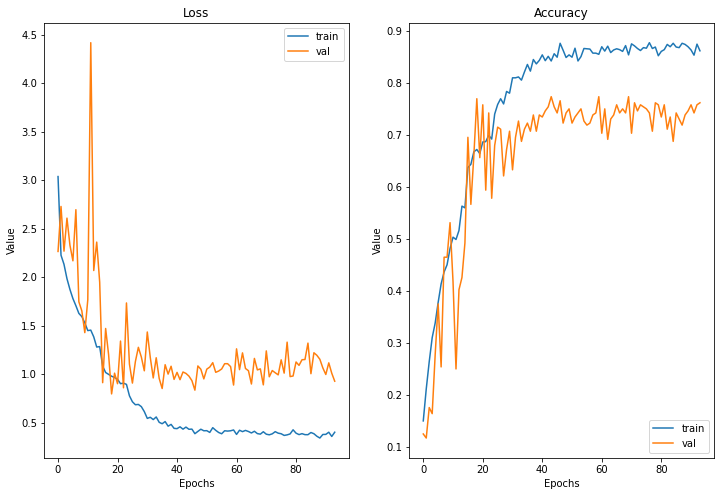

load model and predict
valid acc
8/8 [==============================] - 0s 15ms/step - loss: 0.8565 - accuracy: 0.7539




*******************number_7_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 2.8914 - accuracy: 0.1562
Epoch 00001: val_loss improved from inf to 2.29295, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_7.h5
56/56 [==============================] - 5s 92ms/step - loss: 2.8914 - accuracy: 0.1562 - val_loss: 2.2930 - val_accuracy: 0.1445 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.2201 - accuracy: 0.2366
Epoch 00002: val_loss did not improve from 2.29295
56/56 [==============================] - 4s 66ms/step - loss: 2.2201 - accuracy: 0.2366 - val_loss: 2.6480 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.0190 - accuracy: 0.2879
Epoch 00003: val_loss did not improve from 2.29295
56/56 

56/56 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8895
Epoch 00052: val_loss did not improve from 0.72753
56/56 [==============================] - 4s 68ms/step - loss: 0.3387 - accuracy: 0.8895 - val_loss: 0.9583 - val_accuracy: 0.7578 - lr: 1.2500e-04
Epoch 53/200
56/56 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8856
Epoch 00053: val_loss did not improve from 0.72753
56/56 [==============================] - 4s 67ms/step - loss: 0.3278 - accuracy: 0.8856 - val_loss: 0.8380 - val_accuracy: 0.7617 - lr: 1.2500e-04
Epoch 54/200
56/56 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8650
Epoch 00054: val_loss did not improve from 0.72753
56/56 [==============================] - 4s 67ms/step - loss: 0.3854 - accuracy: 0.8650 - val_loss: 0.8291 - val_accuracy: 0.7773 - lr: 1.2500e-04
Epoch 55/200
56/56 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8828
Epoch 00055: val_loss did not impro

Epoch 80/200
56/56 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9085
Epoch 00080: val_loss did not improve from 0.68200
56/56 [==============================] - 4s 68ms/step - loss: 0.2491 - accuracy: 0.9085 - val_loss: 0.8838 - val_accuracy: 0.8125 - lr: 1.0000e-05
Epoch 81/200
56/56 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9252
Epoch 00081: val_loss did not improve from 0.68200
56/56 [==============================] - 4s 68ms/step - loss: 0.2223 - accuracy: 0.9252 - val_loss: 0.8990 - val_accuracy: 0.7930 - lr: 1.0000e-05
Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9235
Epoch 00082: val_loss did not improve from 0.68200
56/56 [==============================] - 4s 69ms/step - loss: 0.2320 - accuracy: 0.9235 - val_loss: 0.9099 - val_accuracy: 0.7930 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.9169
Epoch 00083: val_loss 

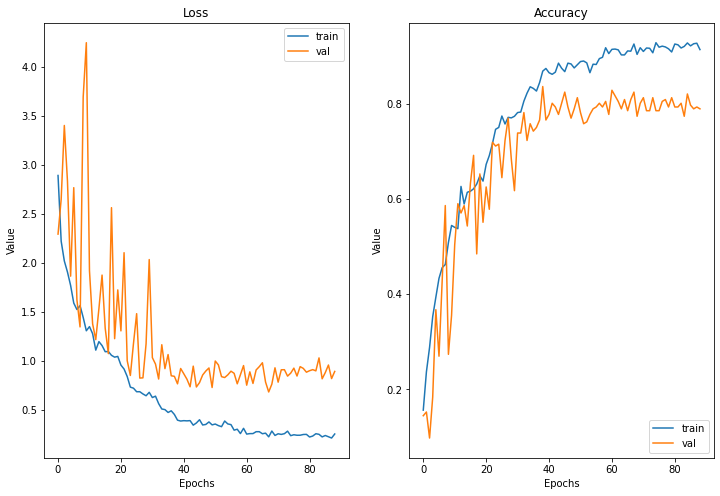

load model and predict
valid acc
8/8 [==============================] - 0s 15ms/step - loss: 0.8287 - accuracy: 0.8086




*******************number_8_kfold_model*******************
Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 2.8603 - accuracy: 0.1501
Epoch 00001: val_loss improved from inf to 2.33844, saving model to ../model/<function DenseNet_121 at 0x7f997ebddd40>_Dexnet121_best_8.h5
56/56 [==============================] - 5s 93ms/step - loss: 2.8603 - accuracy: 0.1501 - val_loss: 2.3384 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 2.3307 - accuracy: 0.2154
Epoch 00002: val_loss did not improve from 2.33844
56/56 [==============================] - 4s 70ms/step - loss: 2.3307 - accuracy: 0.2154 - val_loss: 2.8312 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 2.0734 - accuracy: 0.2517
Epoch 00003: val_loss improved from 2.33844 to 2.18846, s

Epoch 26/200
56/56 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.7338
Epoch 00026: val_loss did not improve from 0.93992
56/56 [==============================] - 4s 71ms/step - loss: 0.7562 - accuracy: 0.7338 - val_loss: 1.1165 - val_accuracy: 0.6914 - lr: 5.0000e-04
Epoch 27/200
56/56 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.7517
Epoch 00027: val_loss did not improve from 0.93992
56/56 [==============================] - 4s 68ms/step - loss: 0.7454 - accuracy: 0.7517 - val_loss: 1.1033 - val_accuracy: 0.7344 - lr: 5.0000e-04
Epoch 28/200
56/56 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.7360
Epoch 00028: val_loss did not improve from 0.93992
56/56 [==============================] - 4s 68ms/step - loss: 0.7573 - accuracy: 0.7360 - val_loss: 0.9562 - val_accuracy: 0.7578 - lr: 5.0000e-04
Epoch 29/200
56/56 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.7383
Epoch 00029: val_loss 

Epoch 81/200
56/56 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8984
Epoch 00081: val_loss did not improve from 0.82863
56/56 [==============================] - 4s 72ms/step - loss: 0.3132 - accuracy: 0.8984 - val_loss: 1.0318 - val_accuracy: 0.8047 - lr: 1.0000e-05
Epoch 82/200
56/56 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.9001
Epoch 00082: val_loss did not improve from 0.82863
56/56 [==============================] - 4s 69ms/step - loss: 0.3039 - accuracy: 0.9001 - val_loss: 0.9453 - val_accuracy: 0.8086 - lr: 1.0000e-05
Epoch 83/200
56/56 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8934
Epoch 00083: val_loss did not improve from 0.82863
56/56 [==============================] - 4s 69ms/step - loss: 0.3143 - accuracy: 0.8934 - val_loss: 1.2569 - val_accuracy: 0.7461 - lr: 1.0000e-05
Epoch 84/200
56/56 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8878
Epoch 00084: val_loss 

Epoch 109/200
56/56 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.9001
Epoch 00109: val_loss did not improve from 0.82863
56/56 [==============================] - 4s 74ms/step - loss: 0.3025 - accuracy: 0.9001 - val_loss: 1.2122 - val_accuracy: 0.7617 - lr: 1.0000e-05
Epoch 110/200
56/56 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8962
Epoch 00110: val_loss did not improve from 0.82863
56/56 [==============================] - 4s 68ms/step - loss: 0.3191 - accuracy: 0.8962 - val_loss: 1.1496 - val_accuracy: 0.7969 - lr: 1.0000e-05
Epoch 111/200
56/56 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8945
Epoch 00111: val_loss did not improve from 0.82863
56/56 [==============================] - 4s 69ms/step - loss: 0.3249 - accuracy: 0.8945 - val_loss: 0.9560 - val_accuracy: 0.8008 - lr: 1.0000e-05
Epoch 112/200
56/56 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8984
Epoch 00112: val_l

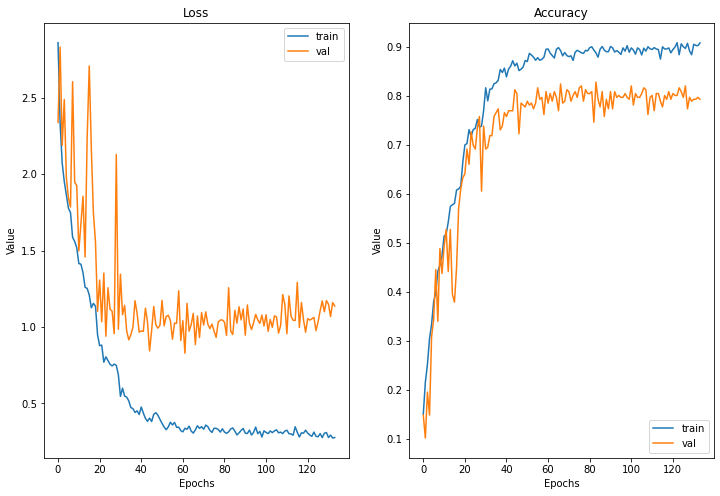

load model and predict
valid acc
8/8 [==============================] - 0s 15ms/step - loss: 1.0100 - accuracy: 0.7930






In [36]:
model121_train, model121_test = get_stacking(DenseNet_121, model_name, X_trains, y_trains, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

### DenseNet-169

In [ ]:
epochs = 200
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet169" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 50 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

In [ ]:
model169_train, model169_test = get_stacking(DenseNet_169, model_name, X_trains, y_trains, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

### DenseNet-201

In [ ]:
epochs = 200
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet201" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 50 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

In [ ]:
model2016_train, model201_test = get_stacking(DenseNet_201, model_name, X_trains, y_trains, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

### DenseNet-265

In [ ]:
epochs = 200
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet265" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 50 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

In [ ]:
model265_train, model265_test = get_stacking(DenseNet_265, model_name, X_trains, y_trains, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

## Pickle 파일 저장

format안에 이름을 설정해주세요  
e.g.  
rx_train_jh  
rx_test_jh  

### RexNet

In [25]:
pickle.dump(model_train, open("../new_data/{}.pkl".format("rx_train_jh"), "wb"))
pickle.dump(model_test, open("../new_data/{}.pkl".format("rx_test_jh"), "wb"))

### DenseNet

In [38]:
pickle.dump(model121_train, open("../new_data/{}.pkl".format("ds121_train_jh"), "wb"))
pickle.dump(model121_test, open("../new_data/{}.pkl".format("ds121_test_jh"), "wb"))

In [ ]:
pickle.dump(model169_train, open("../new_data/{}.pkl".format("ds169_train_jh"), "wb"))
pickle.dump(model169_test, open("../new_data/{}.pkl".format("ds169_test_jh"), "wb"))

In [ ]:
pickle.dump(model201_train, open("../new_data/{}.pkl".format("ds201_train_jh"), "wb"))
pickle.dump(model201_test, open("../new_data/{}.pkl".format("ds201_test_jh"), "wb"))

In [ ]:
pickle.dump(model265_train, open("../new_data/{}.pkl".format("ds265_train_jh"), "wb"))
pickle.dump(model265_test, open("../new_data/{}.pkl".format("ds265_test_jh"), "wb"))